# Libraries

In [1]:
import os

# go up one directory
os.chdir("..")

import pandas as pd 
import numpy as np
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn_extra.cluster import KMedoids
from functions import cosmic_val
from models.aenmf import *
from functions.graph_tools import *
from functions import cosmic_val
from functions import data_handling as dh
import torch.optim as optim
import torch.nn as nn

# set seed
# np.random.seed(15)
# torch.manual_seed(15)

# Data

In [2]:
data_path = "data/catalogues_Ovary_SBS.tsv"
cosmic_path = "data/COSMIC_v3.4_SBS_GRCh37.txt"
output_folder = "data/processed"
output_filename = "Ordered_Ovary_SBS.csv"
ordered_data_path = os.path.join(output_folder, output_filename)

In [3]:
dh.load_preprocess_data(data_path, cosmic_path, sep1 = "\t", sep2 = "\t", output_folder = output_folder, output_filename = output_filename)

Data already exists in  data/processed\Ordered_Ovary_SBS.csv


In [4]:
# load data
data = pd.read_csv(ordered_data_path, index_col = 0)
cosmic = pd.read_csv(cosmic_path, sep = "\t", index_col = 0)

In [5]:
LATENT_DIM = 4
TOLERANCE = 1e-10
MAX_ITERATIONS = 100_000_000
CONSTRAINT = 'abs'
CRITERION = nn.MSELoss() # consider frobenius norm!

In [6]:
losses_train = []
signatures = []
iterations = 4


for i in tqdm(range(iterations)):
    # Train-test split (here it makes sense, we are working with AE)
    train, test = train_test_split(data.T, test_size = 0.2)
    train = train.T
    test = test.T

    # Initializing AENMF model
    aenmf_model = aenmf(input_dim = train.shape[1],
                              latent_dim = LATENT_DIM,
                              constraint= CONSTRAINT,)
    # Training AENMF
    aenmf_mod,training_loss_aenmf, signatures_aenmf, exposures_aenmf = train_aenmf( 
                                                model = aenmf_model,
                                                training_data = train,
                                                criterion = CRITERION,
                                                optimizer = optim.Adam(aenmf_model.parameters(), lr=1e-3),
                                                tol = TOLERANCE,
                                                relative_tol = True,
                                                max_iter = MAX_ITERATIONS)
    

    # Calculating signatures and exposures for NMF
    diagonals_aenmf = signatures_aenmf.sum(axis=0)
    exposures_aenmf = exposures_aenmf.T @ np.diag(diagonals_aenmf)
    signatures_aenmf = (signatures_aenmf) @ np.diag(1 / diagonals_aenmf)
    
    losses_train.append(training_loss_aenmf[-1])
    signatures.append(signatures_aenmf)



100%|██████████| 4/4 [03:32<00:00, 53.12s/it]


In [7]:
print("Losses train: ", np.mean(losses_train))

Losses train:  29805.677612304688


In [8]:
signatures[0].shape

(96, 4)

In [9]:
all_signatures = np.hstack(signatures)

In [10]:
all_signatures.shape

(96, 16)

In [11]:
pam = KMedoids(n_clusters = LATENT_DIM, metric='cosine').fit(all_signatures.T)
labels = pam.labels_
medoid_indices = pam.medoid_indices_
consensus_signatures = all_signatures[:, medoid_indices]

In [12]:
matched_signatures, mean_similarity = cosmic_val.compute_match(consensus_signatures, cosmic)

In [13]:
print(matched_signatures.head())
print("\nMean similarity of the matched signatures: ", mean_similarity)

   Extracted    True  Similarity
0          0   SBS44    0.581362
1          1    SBS5    0.809679
2          2  SBS10a    0.926540
3          3  SBS10c    0.739131

Mean similarity of the matched signatures:  0.7641779906170257


In [14]:
reduced_signatures = PCA(n_components=2).fit_transform(all_signatures.T)

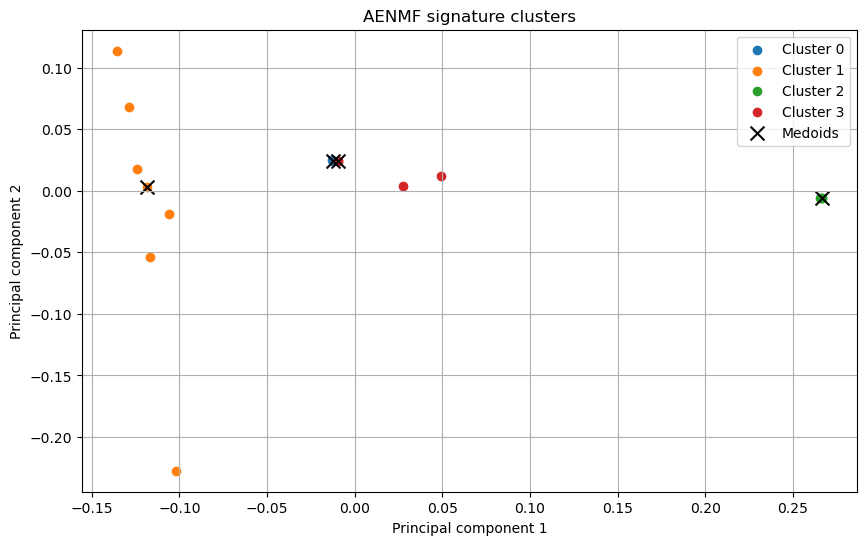

In [15]:
plot_clusters(reduced_signatures, labels, medoid_indices, 4, "AENMF signature clusters")